In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython import display
from Crypto.Util.number import inverse
import random
def gcd(a, b):
    if b == 0:
        return a
    else:
        return gcd(b, a%b)

# Prerequisites

- Elliptic curves (implementation below)
- Group theory -> Finite fields

In [14]:
class EllipticCurveFp(object):
    def __init__(self, a, b, p):
        '''
        input a and b for the y^2 = ax^3 + ax + b form
       
        '''
        self.a = a % p
        self.b = b % p 
        self.p = p
        
        self.discriminant = -16*(4 * pow(a, 3, p) + 27 * pow(b, 2, p)) % p
        if not self.is_smooth():
            raise Exception("the curve %s is not smooth!" % self)
        
        
    def is_smooth(self):
        return self.discriminant!=0
    
    
    def test_point(self, x, y):
        return pow(y, 2, self.p) == ((pow(x, 3, self.p) + self.a * x + self.b ) % self.p)
    
        
    def __str__(self):
        return ('y^2 = x^3 + %Gx + %G mod %G' %(self.a, self.b, self.p))
    
    
    def __eq__(self, other):
        return (self.a, self.b, self.p) == (other.a, other.b, other.p)
    
    
class PointFp(object):
    ''' 
    a point on a curve
    for any point that is not the ideal z = 1
    we consider the ideal to have x = 0, y = 1, z = 0
    '''
    def __init__(self, curve, x, y, z = 1):
        if z == 1:
            self.curve = curve #the elliptic curve containing the point
            self.x, self.y = x % curve.p, y % curve.p
            self.z = z
            if not curve.test_point(self.x, self.y):
                raise Exception("The point %s is not on the given curve %s" %(self, curve))
        else:
            self.x, self.y, self.z = x, y, z
            self.curve = curve


    def __neg__(self):
        return PointFp(self.curve, self.x, -self.y % self.curve.p)
    
    
    def __eq__(self, other):
        if(self.curve == other.curve and self.x == other.x and self.y == other.y):
            return True
        else:
            return False
        
        
    def __add__(self, other):
        if(self.z!=1):
            return other
        elif(other.z!=1):
            return self
        elif(self.x == other.x and self.y == -other.y % self.curve.p):
            return PointFp(self.curve, 0, 1, 0)
        else:
            #doubling
            if self == other:
                num = (3*pow(self.x, 2) + self.curve.a)
                denom = (2*self.y)
                gcd_temp = gcd(denom, self.curve.p)
                if gcd_temp !=1:
                    return PointFp(self.curve, 0, 0, denom)
                else:
                    lam = num * inverse(denom, self.curve.p)
            else :
                num = (self.y - other.y)
                denom = (self.x - other.x)
                gcd_temp = gcd(denom, self.curve.p)
                if gcd_temp !=1:
                    return PointFp(self.curve, 0, 0, denom)
                else:
                    lam =  num * inverse(denom, self.curve.p)
            x_3 = (lam**2 - self.x - other.x) % self.curve.p
            y_3 = (lam*(self.x - x_3) - self.y) % self.curve.p
            return PointFp(self.curve, x_3, y_3)
    
    
    def __sub__(self, other):
        return self + - other
            
        
    def __str__(self):
        return ("(%s, %s, %s)" % (self.x, self.y, self.z))
    
    
    def __mul__(self, n):
        n = n % self.curve.p
        if not isinstance(n, int):
            raise Exception ("can't scale if n isnt integer")
        else:
            if n == 0:
                return PointFp(self.curve, 0, 1, 0)
            else:
                Q = self
                R = self if n & 1 == 1 else PointFp(self.curve, 0, 1, 0)
                i = 2
                while i<=n:
                    Q = Q + Q
                    if n & i == i:
                        R = Q + R
                    i = i << 1 
        return R 
    
    
    def __rmul__(self, n):
        return self * n 
    
    
    def __hash__(self):
        return hash(str(self))

# Theory

- https://www.youtube.com/watch?v=x6vyBb4915Q&list=PLKXdxQAT3tCssgaWOy5vKXAR4WTPpRVYK&index=82&ab_channel=JeffSuzuki
- https://en.wikipedia.org/wiki/Lenstra_elliptic-curve_factorization

**Lagrange's theorem**:
For any finite group $G$, the order (number of elements) of every subgroup $H$ of $G$ divides the order of $G$.

Let $ E: \ Y^2 = X^3 + AX + B \ mod \ N$ where N is not necesarily prime => Let $N = pq$ => 
- Since N is finite, there must be some $k$ for which $kP = 0$ (The point at infinity)
- Therefore the line between (k-1)P and P must have undefined slope
- This will occur when the difference of the x-values shares a common factor with N

*Intuition*:
- $N$ will have subgroups with $N_p$, $N_q$ elements -> from Lagrange's theorem you'll find a $k$ s.t $kP = 0$. Moreover $k = N_p$ which divides N

# Code

Algorithm
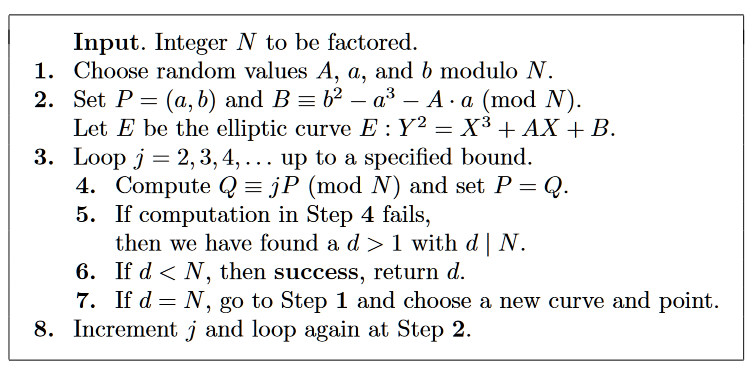

In [15]:
def LenstraFactorizationEC(N, bound = 10000):
    #select random values A, x_p, y_p
    while True:
        A = random.randint(0, max(10, N-1//10))
        x_p = random.randint(0, N-1)
        y_p = random.randint(0, N-1)

        #compute B 
        B = (pow(y_p, 2, N) - pow(x_p, 3, N) - A * x_p) % N

        #set the elliptic curve and the point
        E = EllipticCurveFp(A, B, N)
        P = PointFp(E, x_p, y_p)
        j = 2
        for _ in range(bound): #or to a specific bound
            Q = j * P
            #print('Q = ', Q)
            if Q.z != 1 and Q.z!=0:
                #we found the denominator that can't be inverted
                d = Q.z
                gcd_temp = gcd(d, N)
                if gcd_temp < N:
                    return gcd_temp
                else: 
                    break #if it fails choose another curve
            P = Q
            j+=1
        

In [16]:
print(LenstraFactorizationEC(26167))
print(LenstraFactorizationEC(28102844557))

137
238639


# Resources

- https://en.wikipedia.org/wiki/Lenstra_elliptic-curve_factorization
